In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import Libraries
from osgeo import gdal

import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib import colors



from skimage import exposure
from skimage import feature
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from skimage.color import rgb2gray
from skimage import data

import math

import fastai
from fastai.vision import *
from fastai.gen_doc.nbdoc import *
from fastai.core import *


In [3]:
fastai.__version__

'1.0.50.post1'

In [4]:
# Folder for Training Data
path = os.path.join('training', 'EuroSAT', '2750')

In [5]:
for folder in os.listdir(path):
    print(folder)
    path_ = os.path.join(path, folder)    
    verify_images(path_, delete=True, max_size=500)

AnnualCrop


Forest


HerbaceousVegetation


Highway


Industrial


models


C:\Users\apsac243\Anaconda3\envs\geo\lib\site-packages\fastprogress\fastprogress.py:96: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Pasture


PermanentCrop


Residential


River


SeaLake


In [6]:
# Import Training Data
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.01, size=224, num_workers=0).normalize(imagenet_stats)

In [7]:
data.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [8]:
doc(data.show_batch)

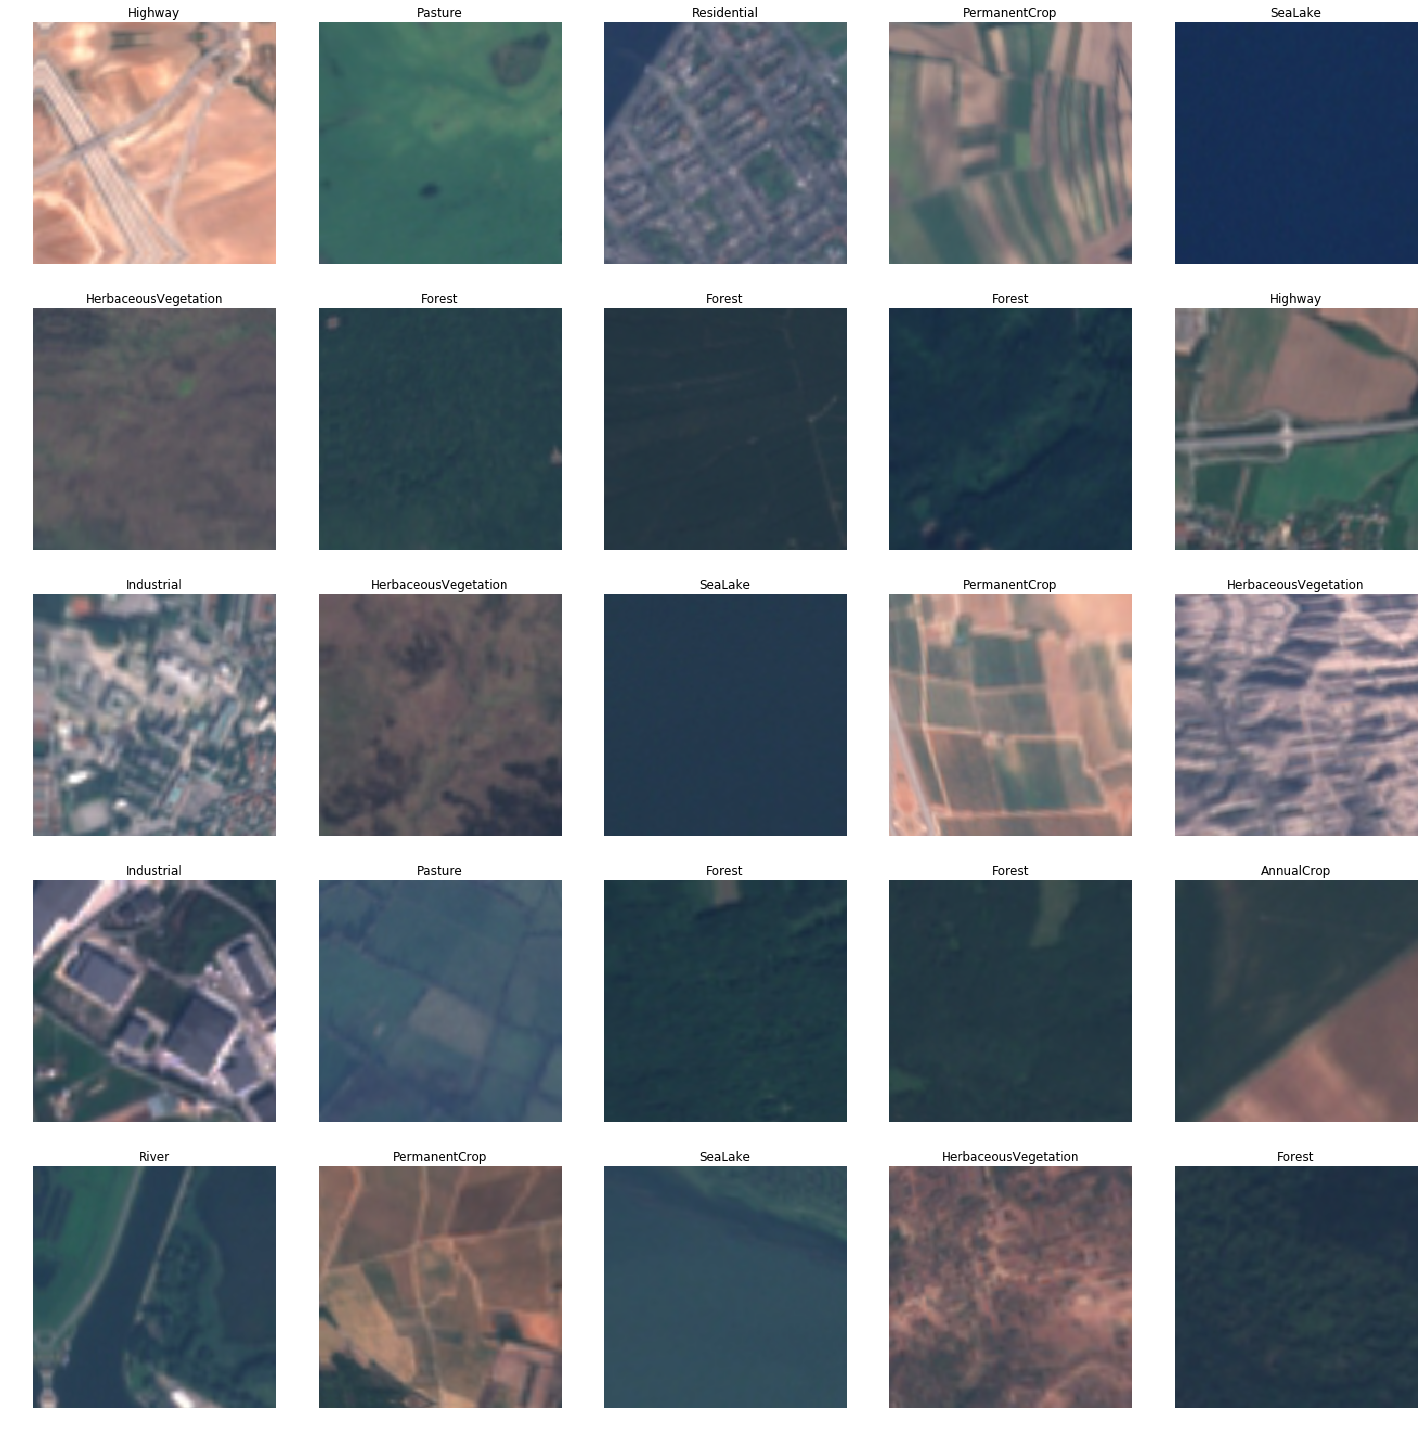

In [9]:
data.show_batch()

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'],
 10,
 26730,
 270)

In [11]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

C:\Users\apsac243\Anaconda3\envs\geo\lib\site-packages\fastai\vision\learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [12]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (24300 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop,AnnualCrop
Path: training\EuroSAT\2750;

Valid: LabelList (2700 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PermanentCrop,Forest,River,Highway,River
Path: training\EuroSAT\2750;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2

In [12]:
doc(learn.fit_one_cycle)

In [ ]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

In [12]:
# Import data folders
data_folder = os.path.abspath("data")

# Set Output Folder
output_folder = os.path.abspath("output")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
    

In [13]:
def chunk_imagery(image, tile_size):
    s = image.shape
    no_rows = math.ceil(s[0]/tile_size)
    no_cols = math.ceil(s[1]/tile_size)
    r = np.array_split(image, no_rows)
    rows = []
    for x in r:
        x = np.array_split(x, no_cols, axis=1)
        rows.append(x)
    return rows
    

In [5]:
# Read Imagery
testfile = os.path.join(data_folder, 'test.tif')

In [6]:
raster_dataset = gdal.Open(testfile, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []

for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)

c:\users\apsac243\envs\geo\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [7]:
# Convert Image to RGB

image = np.dstack([bands_data[:, :, 0], bands_data[:, :, 1], bands_data[:, :, 2]])
image = exposure.rescale_intensity(image, out_range='uint8')
#image = exposure.equalize_hist(image)
#image = exposure.equalize_adapthist(image)
#image = exposure.adjust_sigmoid(image)
rgb_img = image

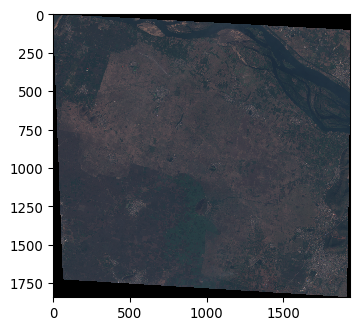

In [8]:
# Show Imagery
plt.figure(num=None, figsize=(4, 4), dpi=96, facecolor='w', edgecolor='k')
plt.imshow(rgb_img)

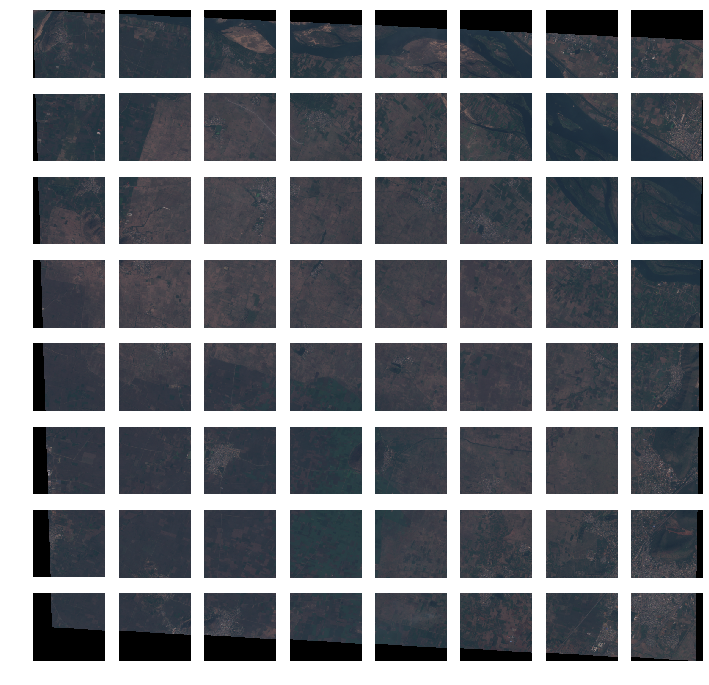

In [9]:
# Chunk the Imagery to parts
chunked = chunk_imagery(rgb_img , 256)
fig, ax = plt.subplots(nrows=len(chunked), ncols=len(chunked[0]), figsize=(12, 12))
for r, row  in enumerate(chunked):
    for c, col in enumerate(row):
        ax[r][c].imshow(col)
        ax[r][c].axis('off')